## 2.1 -  Implement K-means clustering from scratch

### 2.1.1

In [55]:
import numpy as np
import math
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("flower.jpg", cv2.COLOR_BGR2RGB)
img = np.float32(img)


# 1. Randomly select K centers

# 2. Assign each point to the nearest cluster

# Compute new center (mean) for each cluster

def k_means(img, k, iter_n):
    height, width, ch = img.shape
    
    # 1. Randomly select K centers
    # We do this by create a random array of RGB or GRAY values for each K 
    centers = np.random.random_sample((k, ch))*255
    
    cluster_iter = []
    for i in range(iter_n):
        # 2. Assign each point to the nearest cluster
        # Arr shape = (K, height, width), where K is cluster group
        clusters = calc_distance(img, centers)
        cluster_iter.append(clusters)
        
        # 3. Compute new mean for each cluster 
        new_centers = np.empty(shape=(k, ch))
        for j in range(k):
            np.mean(img[clusters[0]==j], axis=0, out=new_centers[j])
            
        # If new centers and centers are the same, exit iteration
        if((centers == new_centers).all()):
            break
        else:
            centers = new_centers
            
    return cluster_iter
    
def calc_distance(points, centers):
    dists = []
    # Calculate the distance between each point and each center
    for center in centers:
        dists.append([img - center])
    dists = np.linalg.norm(dists, axis=-1)
    
    # Return closest center of each point
    return np.argmin(dists, axis=0)
   
def show_plot(imgs, cols=3, isGray = False):  
    for i in range(len(imgs)):
        plt.figure(figsize=(20, 4))
        if(i==5):
            plt.title("Final Iteration")
        else:
            plt.title("Iteration number: "+str(i))
        plt.axis('off')
        if(isGray):
            plt.imshow(clusters[i][0].astype(np.uint8), cmap='gray')
        else:
            plt.imshow(clusters[i][0].astype(np.uint8))
        plt.show()

def plot_figures(imgs, titles=None, max_col=4):
    n = len(imgs)
    rows_per_set = 8 // max_col
    
    

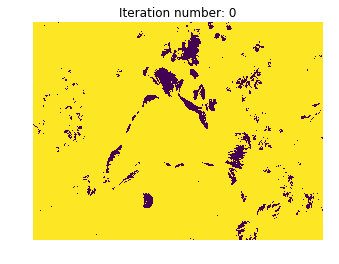

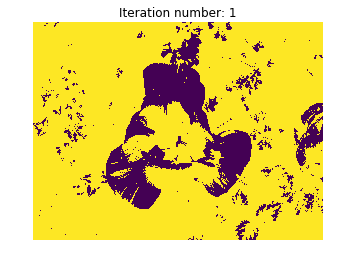

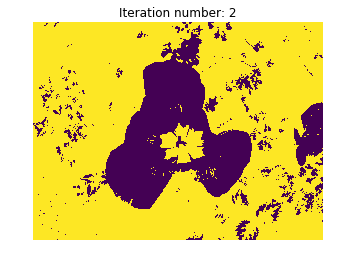

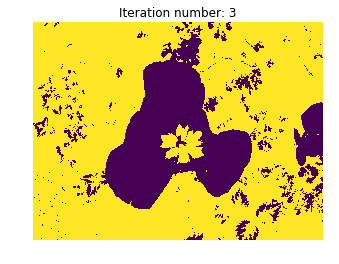

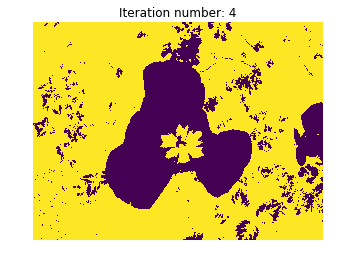

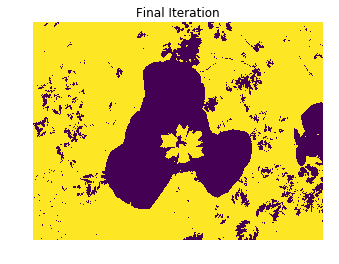

In [56]:
clusters = k_means(img, 2, 6)
show_plot(clusters)

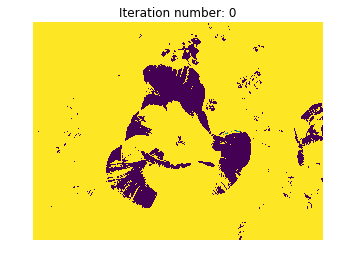

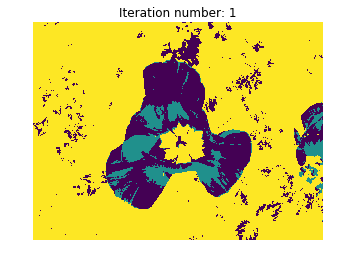

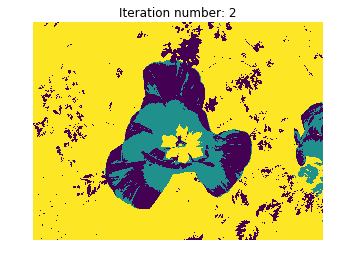

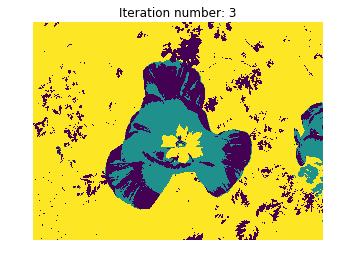

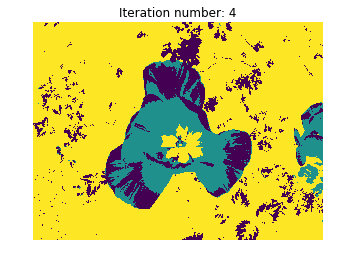

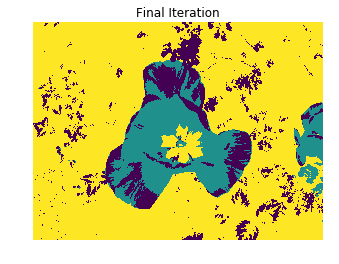

In [57]:
clusters = k_means(img, 3, 6)
show_plot(clusters)

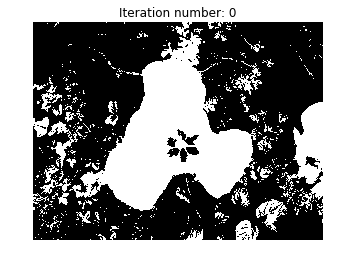

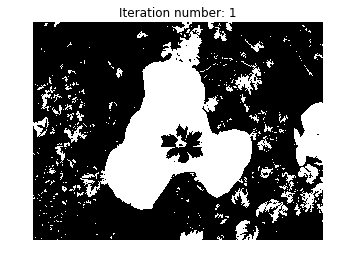

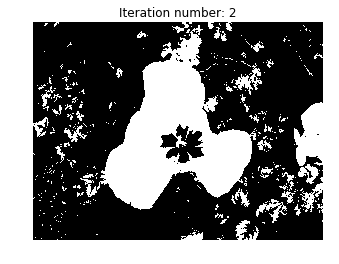

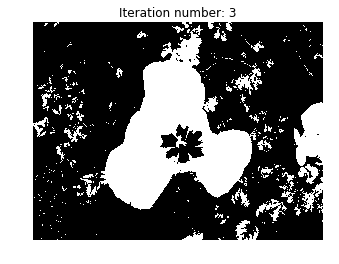

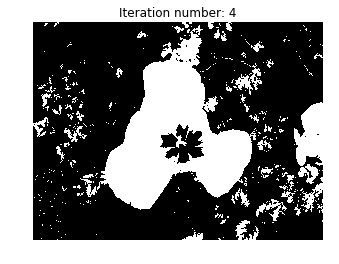

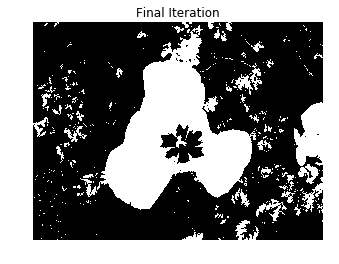

In [58]:
img_gray = cv2.imread("flower.jpg", cv2.COLOR_BGR2RGB)
img_gray = np.float32(img)
clusters = k_means(img_gray, 2, 6)
show_plot(clusters, isGray = True)

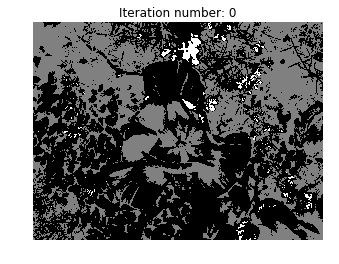

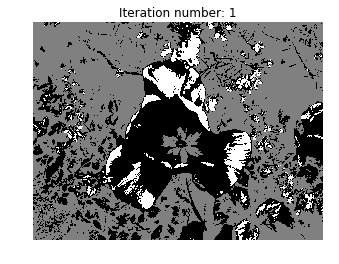

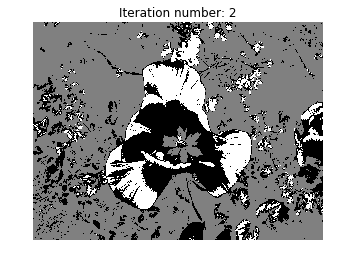

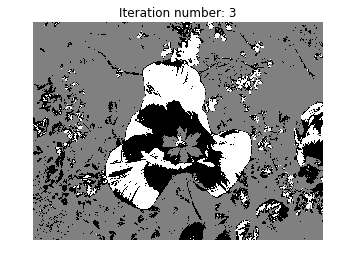

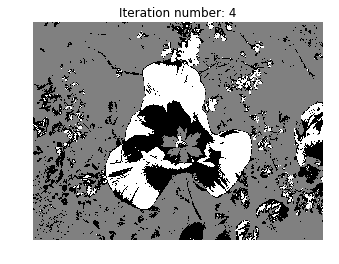

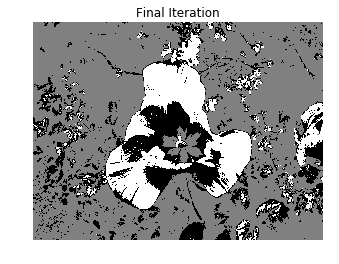

In [59]:
img_gray = cv2.imread("flower.jpg", cv2.COLOR_BGR2RGB)
img_gray = np.float32(img)
clusters = k_means(img_gray, 3, 6)
show_plot(clusters, isGray = True)

In [ ]:
# TODO : compare Color vs Gray scale
